## Imports

In [1]:
import requests
import os
import json

from urllib.request import urlopen
from zipfile import ZipFile
from urllib.request import urlretrieve

from os import listdir
from os.path import isfile, join

import pandas as pd
import glob
import matplotlib.pyplot as plt

## Download and Unzip Data

We have both MAC and Windows user in our group. The data loading code for MAC does not work on Windows. In the cells below, we have downloading data code for MAC. The commented code for downloading data is used by Windows system.

In [2]:
def unzip(url, out_folder):
    try:
        tempzip = open("/tmp/tempfile.zip", "wb")
        tempzip.write(urlopen(url).read())
        tempzip.close()
        zf = ZipFile("/tmp/tempfile.zip")
        zf.extractall(path=out_folder)
        zf.close()
        print(f"Unzipped data to: {os.getcwd()}/{out_folder}")
    except Exception as req:
        raise UnzipFileError(req)

def get_data(url, out_folder):
    try:
        request = requests.get(url)
        if request.status_code == 200:
            if not os.path.exists(os.getcwd() + "/" + out_folder):
                os.makedirs(out_folder + "/")
        
    except Exception as req:
        print("Invalid URL provided.")
        print(req)

    return unzip(url, out_folder)

In [3]:
if not os.path.exists(os.getcwd() + "/data/raw/__MACOSX"):
    pass

else:
    files = glob.glob(os.getcwd() + "/data/raw/__MACOSX/*")
    for f in files:
        os.remove(f)
    os.rmdir(os.getcwd() + "/data/raw/__MACOSX")

if len(os.listdir(os.getcwd() + "/data/raw")) > 0:
    files = glob.glob(os.getcwd() + "/data/raw/*")
    for f in files:
        os.remove(f)
else:
    pass

In [4]:
time_get_data = %timeit -q -o -r 1 get_data(url="https://figshare.com/ndownloader/files/26766812", out_folder="data/raw")
print(f"Time Elapsed (to download and unzip the data): {time_get_data}")

Unzipped data to: /Users/vadim/block6/525/525-Group30/notebooks/data/raw
Unzipped data to: /Users/vadim/block6/525/525-Group30/notebooks/data/raw
Time Elapsed (to download and unzip the data): 2min 9s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [5]:
# article_id = 14096681
# url = f"https://api.figshare.com/v2/articles/{article_id}"
# headers = {"Content-Type": "application/json"}
# output_directory = "data/raw/"

In [6]:
# response = requests.request("GET", url, headers=headers)
# data = json.loads(response.text)
# files = data["files"]
# files

In [7]:
# %%time
# files_to_dl = ["data.zip"]  # feel free to add other files here
# for file in files:
#     if file["name"] in files_to_dl:
#         os.makedirs(output_directory, exist_ok=True)
#         urlretrieve(file["download_url"], output_directory + file["name"])

In [8]:
# %%time
# with ZipFile(os.path.join(output_directory, "data.zip"), 'r') as f:
#     f.extractall(output_directory)

## Combining all .csv files into one DataFrame

In [10]:
path, dirs, files = next(os.walk("data/raw"))
#files.remove("data.zip")
file_count = len(files)

def combine_data():
    combined_df = pd.DataFrame()
    for file in files:
        temp = pd.DataFrame()
        model_name = file.split('_')[0]
        temp = pd.read_csv('data/raw/' + file)
        temp['model'] = model_name
        combined_df = pd.concat([combined_df, temp], axis=0)
    return combined_df

time_combine_data = %timeit -q -o -r 1 combine_data()
print(f"Time Elapsed (to combine the data): {time_combine_data}\n")

combined_df = combine_data()

combined_df.info()

Time Elapsed (to combine the data): 1min 42s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62513863 entries, 0 to 3541152
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   time           object 
 1   lat_min        float64
 2   lat_max        float64
 3   lon_min        float64
 4   lon_max        float64
 5   rain (mm/day)  float64
 6   model          object 
dtypes: float64(5), object(2)
memory usage: 3.7+ GB


In [11]:
if len(os.listdir(os.getcwd() + "/data/processed")) > 0:
    files = glob.glob(os.getcwd() + "/data/processed/*")
    for f in files:
        os.remove(f)

In [12]:
%%time
combined_df.to_csv('data/processed/combined_df.csv')

CPU times: user 5min 57s, sys: 30.3 s, total: 6min 27s
Wall time: 6min 31s


In [13]:
combined_df.head()

,time,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
0,1889-01-01 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.244226e-13,MPI-ESM-1-2-HAM
1,1889-01-02 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.217326e-13,MPI-ESM-1-2-HAM
2,1889-01-03 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.498125e-13,MPI-ESM-1-2-HAM
3,1889-01-04 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.251282e-13,MPI-ESM-1-2-HAM
4,1889-01-05 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.270161e-13,MPI-ESM-1-2-HAM


Time taken to combine data CSV files:

| Team Member | Operating System | RAM | Processor | Is SSD | Time taken (mm:ss) |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Jordan      |   macOS Big Sur  | 8GB |    M1     |   Y    |    |
| Vadim       | macOS Monterey |  32GB  | 2.6 GHz 6-Core Intel Core i7 | Y | 1:42 |
| Nick        |         Win10    |  32GB   |     i7-10750H      |     Y   |        |

# Load the combined CSV to memory and perform a simple EDA

In [14]:
%load_ext memory_profiler

For our EDA, we will just be producing a simple histogram of rainfall amounts.

#### Loading the full dataset

peak memory: 16084.41 MiB, increment: 4206.03 MiB
CPU times: user 1min 32s, sys: 17.5 s, total: 1min 50s
Wall time: 1min 53s


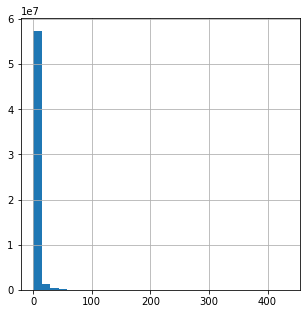

In [15]:
%%time
%%memit
df = pd.read_csv("data/processed/combined_df.csv", index_col=0)
df["rain (mm/day)"].hist(figsize=(5, 5), bins=30)

Time taken load the combined CSV to memory:

| Team Member | Operating System | RAM | Processor | Is SSD | Time taken (mm:ss)|
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Jordan      |   macOS Big Sur  | 8GB |    M1     |   Y    |    1:33    |
| Vadim       | macOS Monterey |  32GB  | 2.6 GHz 6-Core Intel Core i7 | Y | 1:32 |
| Nick        |         Win10    |  32GB   |     i7-10750H      |     Y   |       1:12     |

Observations: loading the whole dataset and performing our simple EDA requires 9562.81 MiB of memory, with a total wall time of 1 minute 33 seconds. 

#### Loading only the columns we need

peak memory: 15827.21 MiB, increment: 0.10 MiB
CPU times: user 44.6 s, sys: 9.51 s, total: 54.1 s
Wall time: 55.2 s


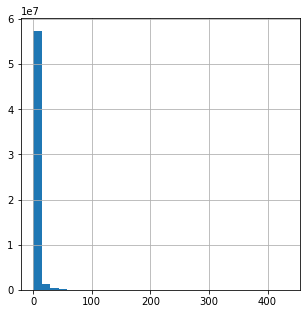

In [16]:
%%time
%%memit
useful_cols = ['time','rain (mm/day)']
df_columns = pd.read_csv("data/processed/combined_df.csv",usecols=useful_cols)
df_columns["rain (mm/day)"].hist(figsize=(5, 5), bins=30)

| Team Member | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Jordan      |   macOS Big Sur  | 8GB |    M1     |   Y    |    55.1s   |
| Vadim       | macOS Monterey |  32GB  | 2.6 GHz 6-Core Intel Core i7 | Y  |     54.1s    |
| Nick        |         Win10    |  32GB   |     i7-10750H      |     Y   |       53.2s     |

Observations: loading only the columnns we needed reduced our peak memory requirement down to 8305.33 MiB of memory, with a total wall time of around 55 seconds (on My MAC). Surprisingly, this did not reduce the peak memory requirement that much! 

#### Changing the dtype 

The code below is adapted from lecture notes. 

In [17]:
print(f"Memory usage with float64: {df[['lat_min','lat_max','lon_min','lon_max','rain (mm/day)']].memory_usage().sum() / 1e6:.2f} MB")
print(f"Memory usage with float32: {df[['lat_min','lat_max','lon_min','lon_max','rain (mm/day)']].astype('float32', errors='ignore').memory_usage().sum() / 1e6:.2f} MB")

Memory usage with float64: 3000.67 MB
Memory usage with float32: 1750.39 MB


peak memory: 18081.89 MiB, increment: 1192.75 MiB
CPU times: user 3.34 s, sys: 2.63 s, total: 5.98 s
Wall time: 6.78 s


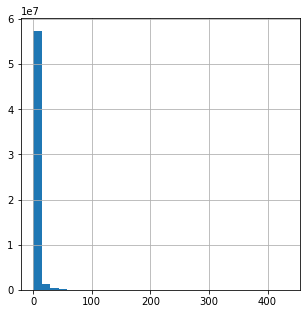

In [21]:
%%time
%%memit
df_dtype = df.astype({'lat_min': 'float32',
                      'lat_max': 'float32',
                      'lon_min': 'float32',
                      'lon_max': 'float32',
                      'rain (mm/day)': 'float32'})
df_dtype["rain (mm/day)"].hist(figsize=(5, 5), bins=30)

| Team Member | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Jordan      |   macOS Big Sur  | 8GB |    M1     |   Y    |    13.8s   |
| Vadim       | macOS Monterey |  32GB  | 2.6 GHz 6-Core Intel Core i7 | Y |       5.98s     |
| Nick        |         Win10    |  32GB   |     i7-10750H      |     Y   |       2.82s     |

Observations: Changing the dtype from float64 to float32 resulted in fairly significant decrease in peak memory usage as well as increase in speed. We needed reduced our peak memory requirement down to 6359.86 MiB, with a total wall time of around 14 seconds (on My MAC). If we wanted to further improve performance we could combine the last two strategies: only loading some columns combined with changing the dtype of those columns. 

# Perform a simple EDA in R

In [ ]:
%load_ext rpy2.ipython

In [ ]:
import pyarrow.dataset as ds
import pyarrow as pa
import pandas as pd
import pyarrow 
from pyarrow import csv
import rpy2_arrow.pyarrow_rarrow as pyra

In [ ]:
%%time
rdf = pyra.converter.py2rpy(pa.Table.from_pandas(df))

In [ ]:
%%time
%%R -i rdf
start_time <- Sys.time()
suppressMessages(library(tidyverse))
suppressMessages(library(stringr))
suppressMessages(library(lubridate))
print(rdf |> head() |> collect())
end_time <- Sys.time()
print(end_time - start_time)

In [ ]:
%%time
%%R
names(rdf)[names(rdf) == "rain (mm/day)"] <- "rain"
rdf_year <- rdf |> 
  mutate(year = as.integer(substr(time, 1, 4))) |> 
  group_by(year) |> 
  summarise(avg_rain = mean(rain, na.rm = TRUE))

print(rdf_year |> collect())

In [ ]:
%%time
%%R

plot <- rdf_year |> 
  ungroup() |> 
  as.data.frame(rdf_year) |> 
  ggplot(aes(x = year, y = avg_rain)) + 
  geom_line() + 
  labs(title = "Average rain volume by year",
       x = "Year",
       y = "Average rain")

plot

#### Comment on loading data in R

As shown in the cells above, loading the data from pandas to R and display in notebook took under 10s. After that, doing regular data wrangling and plotting took another 5s. The overall processing time regarding a 6GiB data set was very fast.  
We chose to use Arrow exchange over other methods. We wanted to load the dataframe from computer's memory directly instead of loading it from disk. As we have done some data loading by using Pandas, we can use Arrow exchange to load data from memory to R. Using Parquet or Feather requires creating a new file on hard disk and loading them into R takes time. However, if we want to work on the dataset again or transfer the data to another person, saving the processed data in Parquet form will be necessary.